In [8]:
data = r'C:\Users\akila\Learning Work\Fine_tuning\PennFudanPed'

In [9]:
import os
os.getcwd()

'C:\\Users\\akila\\Learning Work\\Fine_tuning'

import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image(r"C:\Users\akila\Learning Work\PennFudanPed\PNGImages\FudanPed00046.png")
mask = read_image(r"C:\Users\akila\Learning Work\PennFudanPed\PedMasks\FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [10]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import numpy as np
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt

from torchvision.models.detection import maskrcnn_resnet50_fpn
from engine import train_one_epoch# evaluate
import utils

In [11]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        # target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [12]:
#Object detection and instance segmentation model for PennFudan Dataset


In [13]:
def get_transform():
    return T.Compose([
        T.ToDtype(torch.float32, scale=True),
    ])

In [15]:
root = r"C:\Users\akila\Learning Work\Fine_tuning\PennFudanPed"  # Replace with actual path
dataset = PennFudanDataset(root, transforms=get_transform())
dataset_test = PennFudanDataset(root, transforms=get_transform())

In [16]:
# Split dataset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In [17]:
# --- Load Mask R-CNN Model ---
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2  # 1 class (person) + background

# Get input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with your own
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()


Epoch: [0]  [ 0/60]  eta: 0:03:01  loss: 1.2637 (1.2637)  loss_classifier: 0.7434 (0.7434)  loss_box_reg: 0.4804 (0.4804)  loss_objectness: 0.0239 (0.0239)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 3.0320  data: 0.0630  max mem: 1855
Epoch: [0]  [10/60]  eta: 0:00:52  loss: 0.5928 (0.5967)  loss_classifier: 0.2292 (0.2605)  loss_box_reg: 0.3146 (0.3129)  loss_objectness: 0.0145 (0.0173)  loss_rpn_box_reg: 0.0047 (0.0060)  time: 1.0400  data: 0.1524  max mem: 2395
Epoch: [0]  [20/60]  eta: 0:00:37  loss: 0.3513 (0.4580)  loss_classifier: 0.0987 (0.1688)  loss_box_reg: 0.2287 (0.2717)  loss_objectness: 0.0080 (0.0106)  loss_rpn_box_reg: 0.0063 (0.0069)  time: 0.8419  data: 0.1587  max mem: 3030
Epoch: [0]  [30/60]  eta: 0:00:27  loss: 0.2510 (0.3713)  loss_classifier: 0.0561 (0.1299)  loss_box_reg: 0.1870 (0.2270)  loss_objectness: 0.0008 (0.0076)  loss_rpn_box_reg: 0.0063 (0.0067)  time: 0.8233  data: 0.1559  max mem: 3030
Epoch: [0]  [40/60]  eta: 0:00:17  loss: 0.1717 (0.3220)  loss_c

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.save(model.state_dict(), "Faster_rcnn_pennfudan.pth")


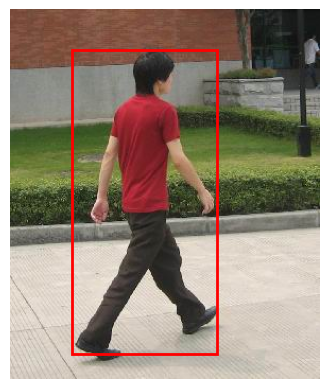

In [24]:
import torchvision.transforms.functional as TF

img, _ = dataset_test[0]  # First test sample
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

# Convert image to NumPy for plotting
img_np = TF.to_pil_image(img)


with torch.no_grad():
    prediction = model([img.to(device)])

for box, score in zip(prediction[0]["boxes"].cpu(), prediction[0]["scores"].cpu()):
    if score > 0.5:
        x1, y1, x2, y2 = box.int()
        plt.gca().add_patch(plt.Rectangle((x1.item(), y1.item()), (x2 - x1).item(), (y2 - y1).item(),
                                          edgecolor="red", linewidth=2, fill=False))

plt.imshow(TF.to_pil_image(img))
plt.axis("off")
plt.show()
